# Project 2

In [ ]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.neighbors import NearestNeighbors

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples

### Importing Data

In [ ]:
krispyDF = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KrispyKreme.csv")
krispyDF.shape

(205, 32)

In [ ]:
#krispyDF.head(30)

## a) make 3 scatterplots using ggplot to show:
#### Sodium_100g vs Total_Fat_100g
#### Sodium_100g vs. Sugar_100g
#### Sugar_100g vs Total_Fat_100g

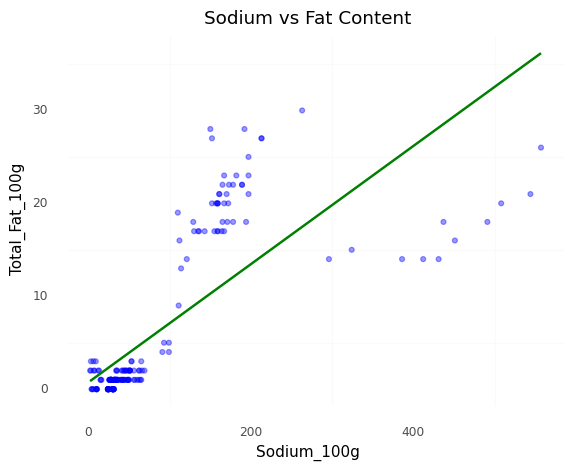

<ggplot: (8771857565555)>

In [ ]:
# Sodium vs Total Fat:
(ggplot(krispyDF, aes(x = "Sodium_100g", y = "Total_Fat_100g")) +
 geom_point(color = "blue", alpha = 0.4) +
 theme_minimal() +
 theme(panel_grid_major_x = element_blank()) +
 theme(panel_grid_major_y = element_blank()) +
 geom_smooth(method = "lm", se=False, color = "green") + 
 labs(title = "Sodium vs Fat Content"))

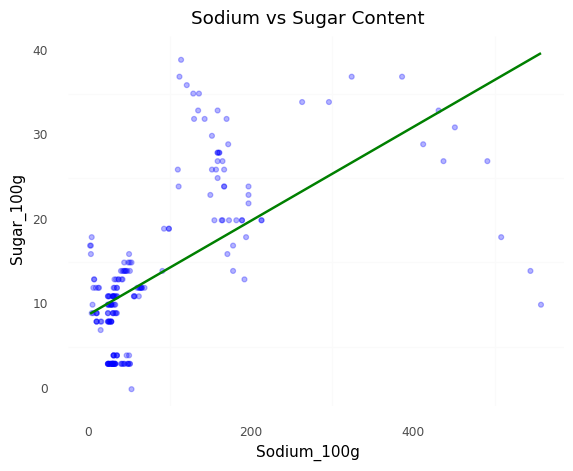

<ggplot: (8771857507560)>

In [ ]:
# Sodium vs Sugar:
(ggplot(krispyDF, aes(x = "Sodium_100g", y = "Sugar_100g")) +
 geom_point(color = "blue", alpha = 0.3) +
 theme_minimal() +
 theme(panel_grid_major_x = element_blank()) +
 theme(panel_grid_major_y = element_blank()) +
 geom_smooth(method = "lm", se=False, color = "green") + 
 labs(title = "Sodium vs Sugar Content"))

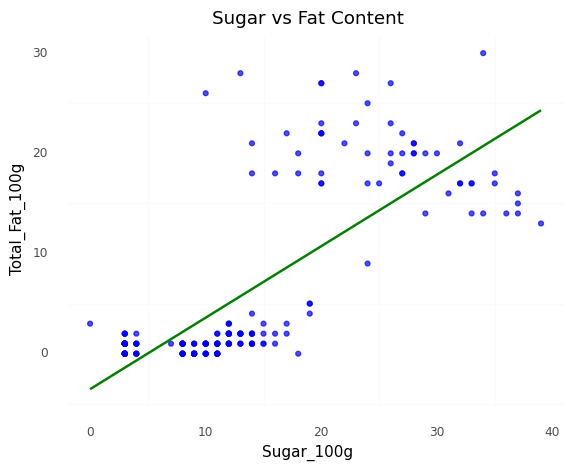

<ggplot: (8771854829047)>

In [ ]:
# Sugar vs Total_Fat_100g:
(ggplot(krispyDF, aes(x = "Sugar_100g", y = "Total_Fat_100g")) +
 geom_point(color = "blue", alpha = 0.7) +
 theme_minimal() +
 theme(panel_grid_major_x = element_blank()) +
 theme(panel_grid_major_y = element_blank()) +
 geom_smooth(method = "lm", se=False, color = "green") + 
 labs(title = "Sugar vs Fat Content"))

## b)
#### Using the scatterplots from part a as well as the donuts dataset, thouroughly discuss which clustering method (KMeans, Gaussian Mixture Models (EM), Hierarchical Clustering, or DBSCAN) you think would be best for this data and WHY. Be sure to include discussions of assumptions each algorithm does/does not make, and what types of data they are good/bad for (mention each of the 4 algorithms at least once) and how they apply to this specific dataset. (IN A MARKDOWN CELL)

**KMeans** works well with even cluster size and a reasonable amount of clusters. This algorithm assumes that all of the clusters are spherical and that there are roughly the same number of datapoints in each cluster. Since the scatterplots show somewhat circular groupings, KMeans would work alright here. Also, if we inspect the Sodium vs Fat and Sodium vs Sugar plots, there are a lot more points in the clusters with low sodium and low fat than the other clusters, so we break the second assumption (roughly the same number of points in each cluster). This is an okay clustering algorithm for this dataset, and is the third best.

**GMM** allows us to model clusters with non-uniform variance, so it would work better than KMeans for this particular dataset. We also have to choose the number of clusters, but it's pretty obvious that we would want about 3 clusters when looking at the scatterplots. We also do not need to label noise points as there are very few if any outliers, so I would pick this algorithm.

**DBSCAN** is worse for clusters with different densities and is not great for overlapping clusters. We have uneven cluster sizes in all plots besides in the Fat vs Sugar plot, but they don't overlap very much. Since we also do not have much noise at all, that advantage of DBSCAN is not useful. This is the worst algorithm for this dataset.

**Hierarchicial Clustering** models a relationship with hierarchy. In this dataset, we have a few different kinds of food/drink, which can then be broken down into further subcategories. We have a hierarchy structure, so it would work well, but it is a slow algorithm and there is no way to unmerge clusters. We do not need to unmerge clusters once the model is built. I think this is the second best algorithm.

Best algorithm: GMM

Worst algorithm: DBSCAN

Overall, any of these algorithms would work alright, with silhouette scores around 0.74 with proper hyperparameters.

## c) 

Implement the TWO algorithms you think will work BEST (1 algo) and WORST(1 algo) here using all 3 variables Sodium_100g, Total_Fat_100g and Sugar_100g, and describe how you chose any hyperparameters (such as distance, number of clusters, min_samples, eps, linkage...etc). Make sure to z-score your variables. (IN A MARKDOWN CELL)

### GMM

In [ ]:
# BEST: GMM
features = ["Sugar_100g", "Sodium_100g", "Total_Fat_100g"]

X = krispyDF[features]

z = StandardScaler()
X[features] = z.fit_transform(X[features])

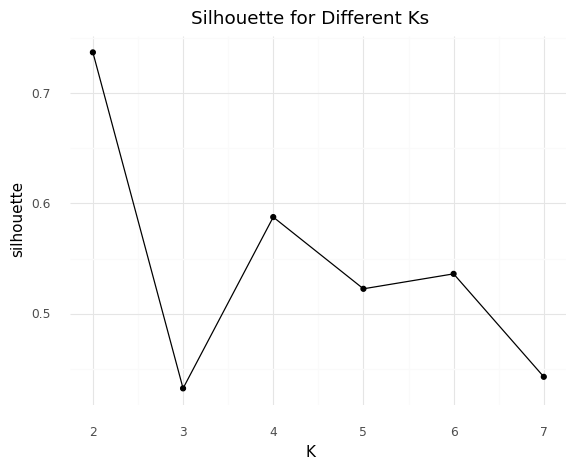

<ggplot: (8771854832942)>

In [ ]:
n_components = [2,3,4,5,6,7]

sils = []

for n in n_components:
  gmm = GaussianMixture(n_components=n)
  gmm.fit(X[features])

  colName = "assignments" + str(n)
  clusters = gmm.predict(X[features])

  X[colName] = clusters

  sils.append(silhouette_score(X[features], clusters))

sil_df = pd.DataFrame({"K": n_components,
                      "silhouette": sils})

(ggplot(sil_df, aes(x = "K", y = "silhouette")) + geom_point() + 
geom_line() + 
theme_minimal() + 
labs(title = "Silhouette for Different Ks"))

This confirms that using k = 3 is a good number of clusters.

In [ ]:
# model
gmm = GaussianMixture(n_components = 3)
gmm.fit(X[features])

In [ ]:
# predictions
clusterGMM = gmm.predict(X[features])

In [ ]:
# silhouette score
silhouette_score(X[features], clusterGMM)

0.5654290897849948

## DBSCAN

In [ ]:
mins = 3
nn = NearestNeighbors(n_neighbors=mins+1)

nn.fit(X)

distances, neighbors = nn.kneighbors(X)

In [ ]:
# sort the distances
distances = np.sort(distances[:, mins], axis = 0)

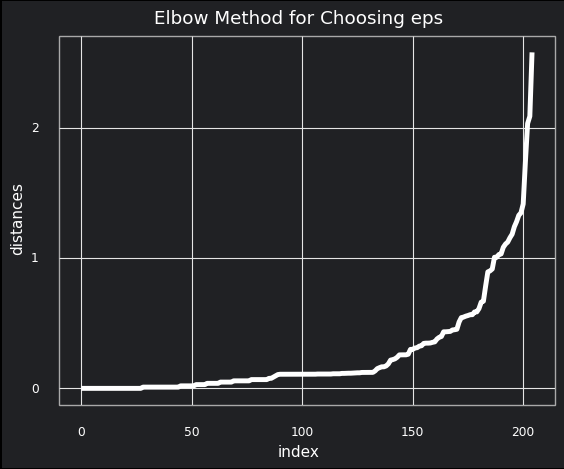

<ggplot: (8771854775435)>

In [ ]:
#plot the distances
distances_df = pd.DataFrame({"distances": distances,
                             "index": list(range(0,len(distances)))})
(ggplot(distances_df, aes(x = "index", y = "distances")) +
 geom_line(color = "white", size = 2) + theme_minimal() +
 labs(title = "Elbow Method for Choosing eps") +
 theme(panel_grid_minor = element_blank(),
      rect = element_rect(fill = "#202124ff"),
      axis_text = element_text(color = "white"),
      axis_title = element_text(color = "white"),
      plot_title = element_text(color = "white"),
      panel_border = element_line(color = "darkgray")
      ))

In [ ]:
# WORST: DBSCAN
DBS = DBSCAN(eps=0.8,min_samples=9)

DBS.fit(X[features])
X["clusterDBS"] = DBS.labels_
silhouette_score(X[features],X["clusterDBS"])

0.7322719615248882

### Hyperparameter choice:
GMM:
n_components: I chose 3 clusters because 1. when I look at the scatter plots I see three distinct regions of points, and 2. when I plot the silhouette score for different k values, 3 clusters gives me the best score.

DBSCAN:
eps: I used the elbow method to find the best eps radius.

min_samples: the clusters I want to be created have at least 9 points in them (taken from the scatter plots).

## d)
### Thouroughly discuss the performance of your clustering models. For each algorithm (best and worst):
#### Which metric did you use to asses your model?
#### How did your model perform?
#### Remake the 3 graphs from part a, but color by cluster assignment. Describe what characterizes each cluster, and give an example of a label for that cluster (e.g. "these donuts are low fat, and low sugar so I would call these healthy donuts"

### GMM

#### I used silhouette score to assess this model.
#### With a score of 0.741, this model performed very well. It has high separation and high cohesion.

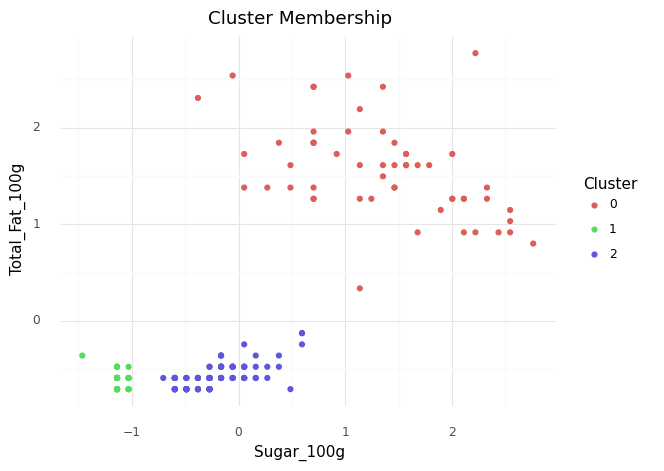

<ggplot: (8771852071283)>

In [ ]:
krispyDF["clusterGMM"] = clusterGMM

(ggplot(X, aes(x = "Sugar_100g", y = "Total_Fat_100g", color = "factor(clusterGMM)")) + geom_point() + 
theme_minimal() + labs(title = "Cluster Membership") + scale_color_discrete(name ="Cluster"))

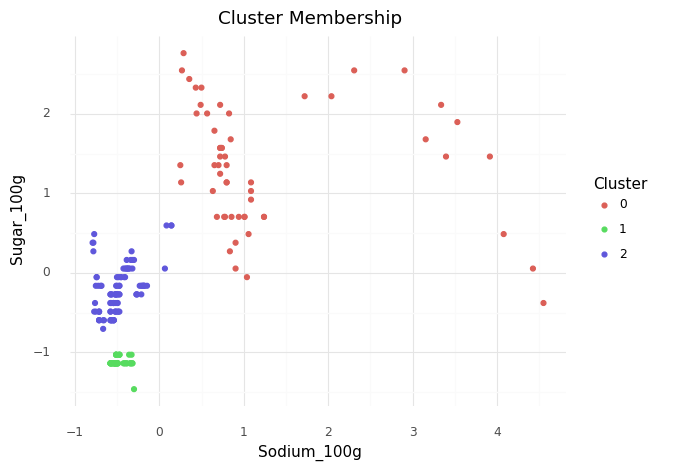

<ggplot: (8771857690896)>

In [ ]:
(ggplot(X, aes(x = "Sodium_100g", y = "Sugar_100g", color = "factor(clusterGMM)")) + geom_point() + 
theme_minimal() + labs(title = "Cluster Membership") + scale_color_discrete(name ="Cluster"))

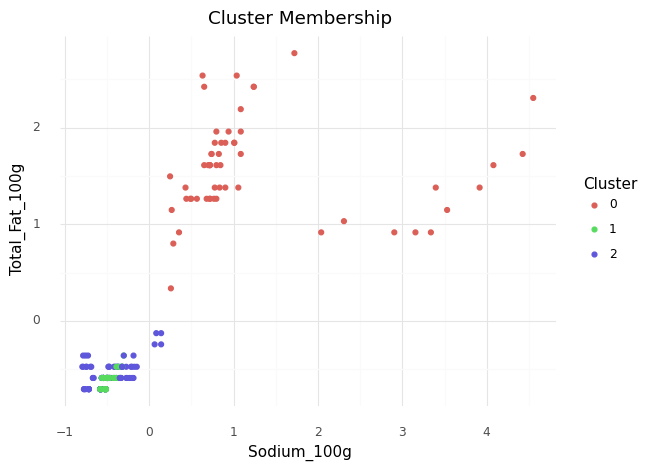

<ggplot: (8771851956956)>

In [ ]:
(ggplot(X, aes(x = "Sodium_100g", y = "Total_Fat_100g", color = "factor(clusterGMM)")) + geom_point() + 
theme_minimal() + labs(title = "Cluster Membership") + scale_color_discrete(name ="Cluster"))

In [ ]:
# krispyDF.tail(20)

In [ ]:
# krispyDF.head(20)

#### Cluster 0: Low fat, low sodium, and low to moderate sugar. These are probably the drinks that Krispy Kreme sells: Coffee and Chillers.

#### Cluster 1: Moderate to high fat, moderate sodium, and moderate to high sugar. These are typical doughnuts (glazed, chocolate, cinnamon)

#### Cluster 2: Moderate to high fat, high sodium, and high sugar. These are the extremely unhealthy doughnuts, probably due to size or a overload of unhealthy substances.

## DBSCAN

#### I used silhouette score to assess this model.
#### With a score of 0.732, this model performed well, but not as well as GMM.

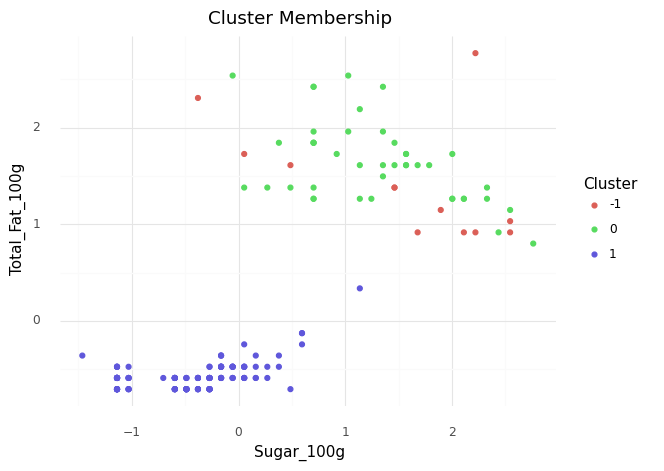

<ggplot: (8771851934630)>

In [ ]:
(ggplot(X, aes(x = "Sugar_100g", y = "Total_Fat_100g", color = "factor(clusterDBS)")) + geom_point() + 
theme_minimal() + labs(title = "Cluster Membership") + scale_color_discrete(name ="Cluster"))

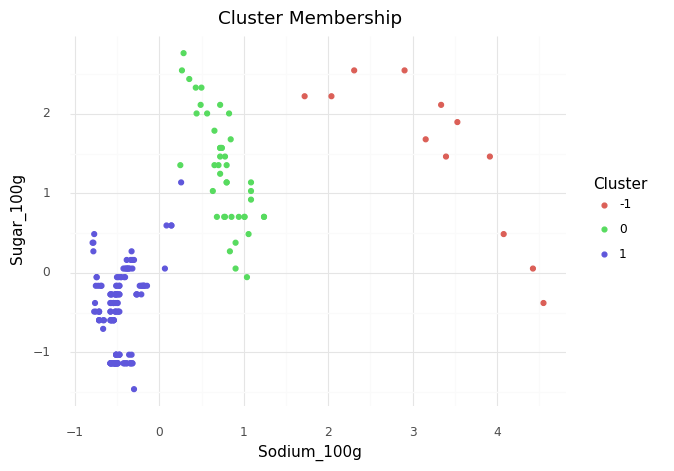

<ggplot: (8771851874576)>

In [ ]:
(ggplot(X, aes(x = "Sodium_100g", y = "Sugar_100g", color = "factor(clusterDBS)")) + geom_point() + 
theme_minimal() + labs(title = "Cluster Membership") + scale_color_discrete(name ="Cluster"))

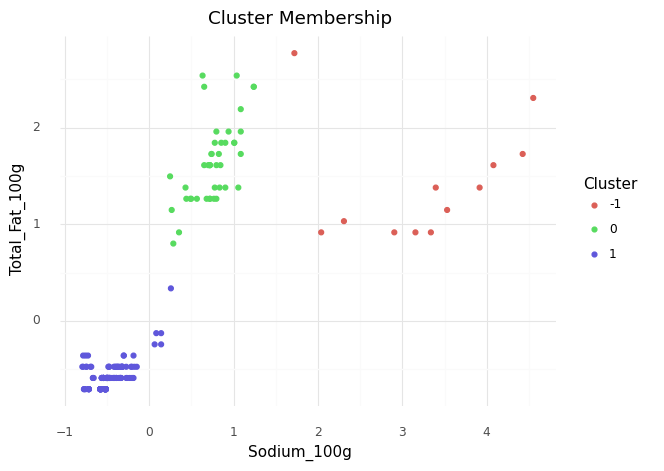

<ggplot: (8771851871169)>

In [ ]:
(ggplot(X, aes(x = "Sodium_100g", y = "Total_Fat_100g", color = "factor(clusterDBS)")) + geom_point() + 
theme_minimal() + labs(title = "Cluster Membership") + scale_color_discrete(name ="Cluster"))

#### Cluster 1: Low fat, low sodium, and low to moderate sugar. These are probably the drinks that Krispy Kreme sells: Coffee and Chillers.

#### Cluster 0: Moderate to high fat, moderate sodium, and moderate to high sugar. These are typical doughnuts (glazed, chocolate, cinnamon)

#### Cluster -1: Moderate to high fat, high sodium, and high sugar. These are the extremely unhealthy doughnuts, probably due to size or a overload of unhealthy substances.

##e)
### Choose ONE other of the _100g variables from the data set to add to your clustering model to improve it.

#### Explain why you chose this variable. Either based on improvement in metrics, or outside knowledge you have about food/donuts.
#### Make a new model, identical to the model you thought would be best in part c, but also including your new variable.
#### Did this variable improve the fit of your clustering model? How can you tell?

### I am choosing Carbohydrates_100g as my predictor.

#### in my research of different kinds of doughnuts, there seems to be a large difference in carbs for each type. Also, the GM model will diffferentiate between drinks and doughnuts because drinks have less carbs across the board than doughnuts.

In [ ]:
updatedFeatures = ["Sugar_100g", "Sodium_100g", "Total_Fat_100g", "Carbohydrates_100g"]

X = krispyDF[updatedFeatures]

z = StandardScaler()

X[updatedFeatures] = z.fit_transform(X[updatedFeatures])

In [ ]:
gmm = GaussianMixture(n_components = 3)
gmm.fit(X[updatedFeatures])

clusterGMM = gmm.predict(X[updatedFeatures])

silhouette_score(X[updatedFeatures], clusterGMM)

0.7489100196846615

#### Yes, this variable slightly improved my model, since the silhouette score raised from 0.741 to 0.749.

In [1]:
# doesn't show this cells output when downloading PDF
!pip install gwpy &> /dev/null

# installing necessary files
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

# installing pypandoc
!pip install pypandoc

# connecting your google drive
from google.colab import drive
drive.mount('/content/drive')

# copying your file over. Change "Class6-Completed.ipynb" to whatever your file is called (see top of notebook)
!cp "drive/My Drive/Colab Notebooks/CPSC392/Project2.ipynb" ./

# Again, replace "Class6-Completed.ipynb" to whatever your file is called (see top of notebook)
!jupyter nbconvert --to PDF "Project2.ipynb"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (2.5-3build2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 javascript-common libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1
  libgs9 libgs9-common libharfbuzz-icu0 libidn11 libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpdfbox-java libptexenc1 libruby2.7 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-g